In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import ExponentialSmoothing
from math import sqrt
from sklearn.metrics import mean_squared_error

# Data Loading and pre-processing

In [7]:
# Loading data temperature
data = [41.7275,  24.0418,  32.3281,  37.3287,  46.2132,  29.3463, 36.4829,  42.9777,  48.9015,  31.1802,  37.7179,  40.4202, 51.2069,  31.8872,  40.9783,  43.7725,  55.5586,  33.8509, 42.0764,  45.6423,  59.7668,  35.1919,  44.3197,  47.9137]
index= pd.date_range(start='2005', end='2010-Q4', freq='QS-OCT')
dataset = pd.Series(data, index)

In [8]:
dataset[0:5]

2005-01-01    41.7275
2005-04-01    24.0418
2005-07-01    32.3281
2005-10-01    37.3287
2006-01-01    46.2132
Freq: QS-OCT, dtype: float64

In [9]:
# Variable definition
split_ratio = 0.7

In [14]:
# Doing a slit of aust between train and test
train = dataset[0:int(round(len(dataset)*0.7,0))]
test = dataset[int(round(len(dataset)*0.7,0)):]

In [17]:
print("Length of dataset:", len(dataset))
print("Length of train:", len(train))
print("Length of test:", len(test))
print("Check:", len(dataset)-len(train)-len(test))

Length of dataset: 24
Length of train: 17
Length of test: 7
Check: 0


# Modelling

In [18]:
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [27]:
model = ExponentialSmoothing(train, seasonal_periods=4, trend='add', seasonal='add').fit(use_boxcox=True)

/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [1]:
# OK
# create a set of exponential smoothing configs to try
def exp_smoothing_configs(seasonal=[None]):
    models = list()
    # define config lists
    t_params = ['add','mul', None]
    d_params = [True, False]
    s_params = ['add','mul', None]
    p_params = seasonal
    b_params = [True, False]
    r_params = [True, False]
    # create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            models.append(cfg)
    return models

# Creating list of configuration possible
cfg_list = exp_smoothing_configs(seasonal=[4])

In [2]:
cfg_list

[['add', True, 'add', 4, True, True],
 ['add', True, 'add', 4, True, False],
 ['add', True, 'add', 4, False, True],
 ['add', True, 'add', 4, False, False],
 ['add', True, 'mul', 4, True, True],
 ['add', True, 'mul', 4, True, False],
 ['add', True, 'mul', 4, False, True],
 ['add', True, 'mul', 4, False, False],
 ['add', True, None, 4, True, True],
 ['add', True, None, 4, True, False],
 ['add', True, None, 4, False, True],
 ['add', True, None, 4, False, False],
 ['add', False, 'add', 4, True, True],
 ['add', False, 'add', 4, True, False],
 ['add', False, 'add', 4, False, True],
 ['add', False, 'add', 4, False, False],
 ['add', False, 'mul', 4, True, True],
 ['add', False, 'mul', 4, True, False],
 ['add', False, 'mul', 4, False, True],
 ['add', False, 'mul', 4, False, False],
 ['add', False, None, 4, True, True],
 ['add', False, None, 4, True, False],
 ['add', False, None, 4, False, True],
 ['add', False, None, 4, False, False],
 ['mul', True, 'add', 4, True, True],
 ['mul', True, 'add', 

In [29]:
t,d,s,p,b,r = cfg_list[0]

In [39]:
model = ExponentialSmoothing(train, trend=t, damped=d, seasonal=s, seasonal_periods=p).fit(optimized=True,use_boxcox=b,remove_bias=r)

/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [40]:
model.predict(start=len(train)+1,end=len(test)+len(train))

2009-07-01    40.636131
2009-10-01    44.636349
2010-01-01    54.066193
2010-04-01    34.125883
2010-07-01    41.120748
2010-10-01    45.070507
2011-01-01    54.464844
Freq: QS-OCT, dtype: float64

In [68]:
# one-step Holt Winters Exponential Smoothing forecast
def exp_smoothing_forecast_grid_search(train, test, configurations):
    best_config = ""
    best_rmse = 99999
    for i in range(len(configurations)):
        try:
            t,d,s,p,b,r = configurations[i]
            # define model
            model = ExponentialSmoothing(train, trend=t, damped=d, seasonal=s, seasonal_periods=p).fit(optimized=True,use_boxcox=b,remove_bias=r)
            # fit model
            # make one step forecast
            pred = model.predict(start=len(train),end=len(test)+len(train)-1)
            temp_indicator = measure_rmse(test,pred)
            if temp_indicator < best_rmse:
                best_rmse = temp_indicator
                best_config = configurations[i]
        except:
            print("error")
    print(best_config)
    print(best_rmse)
    return(best_config)

In [69]:
best_parameters = exp_smoothing_forecast_grid_search(train, test, cfg_list)

/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: Converge

error
error
error
error
error
error
error
error
error
error
error
error
['add', False, 'mul', 4, False, True]
1.415947649716024


In [63]:
cfg_list[2]

['add', True, 'add', 4, False, True]

In [64]:
best_parameters

['mul', True, None, 4, False, False]

# Best model

In [70]:
t,d,s,p,b,r = best_parameters

# define model
model = ExponentialSmoothing(train, trend=t, damped=d, seasonal=s, seasonal_periods=p).fit(optimized=True,use_boxcox=b,remove_bias=r)
# make one step forecast
pred = model.predict(start=len(train),end=(len(test)+len(train)-1))
temp_indicator = measure_rmse(test,pred)
print(temp_indicator)

1.415947649716024


In [71]:
df = pd.DataFrame(columns=["actual","forecast"])
df.actual = train.append(test)
df.forecast = train.append(pred)
df

,actual,forecast
2005-01-01,41.7275,41.727500
2005-04-01,24.0418,24.041800
2005-07-01,32.3281,32.328100
2005-10-01,37.3287,37.328700
2006-01-01,46.2132,46.213200
2006-04-01,29.3463,29.346300
2006-07-01,36.4829,36.482900
2006-10-01,42.9777,42.977700
2007-01-01,48.9015,48.901500
2007-04-01,31.1802,31.180200


# Graphic visualisation

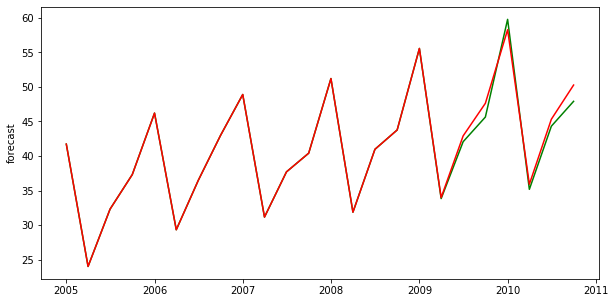

In [72]:
# Creation of a plot // Density level vs average docks

fig, axis = plt.subplots(figsize=(10,5))
sns.lineplot(x=df.index, y="actual",data=df, color="green")
sns.lineplot(x=df.index, y="forecast",data=df, color="red")

plt.show()